In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

import lib
%matplotlib inline

In [2]:
cal_imgs = glob.glob('./camera_cal/calibration*.jpg')
test_images = glob.glob('./test_images/test*.jpg')

# Calibration

In [3]:
objp = np.zeros((9*6, 3), np.float32)
objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

objpoints = []
imgpoints = []

for fname in cal_imgs:
    img = mpimg.imread(fname)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

    if ret == True: 
        imgpoints.append(corners)
        objpoints.append(objp)

In [4]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

### test chessboard images

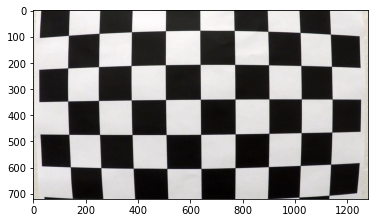

In [5]:
chessboard = mpimg.imread(cal_imgs[10])
plt.imshow(chessboard)

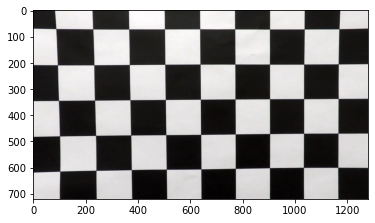

In [6]:
plt.imshow(cv2.undistort(chessboard, mtx, dist))

### test a road image

In [7]:
test_image_dist = mpimg.imread(test_images[2])

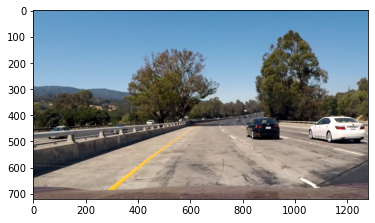

In [8]:
plt.imshow(test_image_dist)

In [9]:
test_image = cv2.undistort(test_image_dist, mtx, dist)

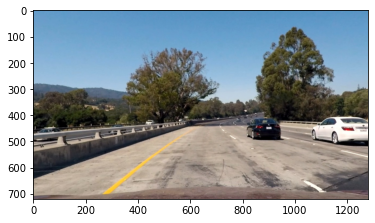

In [10]:
plt.imshow(test_image)

# Thresholding

## Gradient

### Sobel for x direction

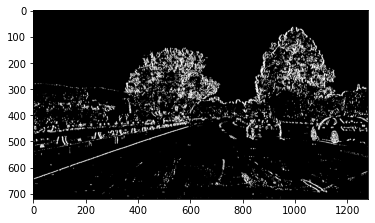

In [11]:
x_binary = lib.abs_sobel_thresh(test_image, orient='x', sobel_kernel=5, thresh=(20, 150))
plt.imshow(x_binary, cmap='gray')

## HLS

### S channel

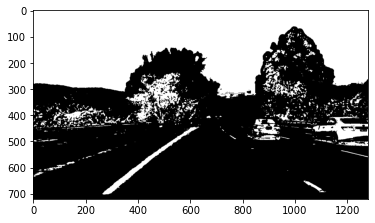

In [12]:
s_binary = lib.s_channel_threshold(test_image, thresh=(90, 255))[1]
plt.imshow(s_binary, cmap='gray')

### H channel

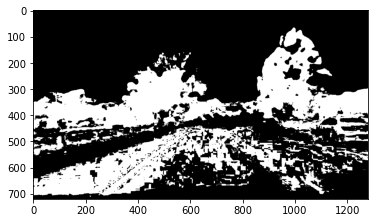

In [13]:
h_binary = lib.h_channel_threshold(test_image, thresh=(15, 50))[1]
plt.imshow(h_binary, cmap='gray')

## Combined HLS and Sobel thresholds

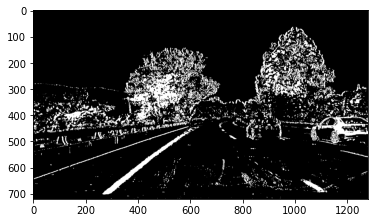

In [14]:
combined_binary = np.zeros_like(s_binary)
combined_binary[((h_binary == 1) & (s_binary == 1)) | (x_binary == 1)] = 1
plt.imshow(combined_binary, cmap='gray')

# Perspective Transform

In [15]:
warped, M, M_inv = lib.warp(combined_binary)

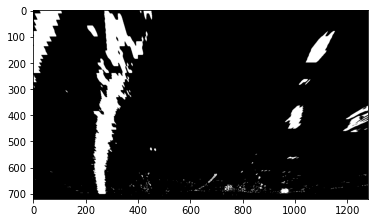

In [16]:
plt.imshow(warped, cmap ='gray')

# Fit lines

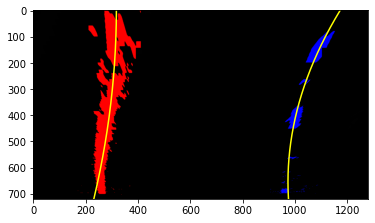

In [17]:
out_img, left_fitx, right_fitx = lib.fit_polynomial(warped, 5)

ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.imshow(out_img)

# Calculate Curvature

In [18]:
rad = lib.calculateCurvature(right_fitx.copy(), ploty.copy())

In [19]:
dsp = lib.calculateDisplacement(right_fitx.copy(), left_fitx.copy())

# Project back

In [20]:
res = lib.unwarp(warped, test_image_dist, M_inv, left_fitx, right_fitx)

In [21]:
res = lib.addText(res, rad, dsp)

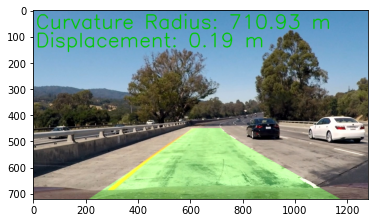

In [22]:
plt.imshow(res)

# Video pipeline

In [23]:
def pipeline(image):

    #Undistort
    img = cv2.undistort(image, mtx, dist)
    
    #Thresholding
    x_binary = lib.abs_sobel_thresh(img, orient='x', sobel_kernel=5, thresh=(20, 150))
    s_binary = lib.s_channel_threshold(img, thresh=(90, 255))[1]
    h_binary = lib.h_channel_threshold(img, thresh=(15, 50))[1]
    
    combined_binary = np.zeros_like(s_binary)
    combined_binary[((h_binary == 1) & (s_binary == 1)) | (x_binary == 1)] = 1
    
    #Perspective Transform
    warped, M, M_inv = lib.warp(combined_binary)
    
    #Line Fitting
    left_fitx, right_fitx = lib.fit_polynomial(warped, 5)[1:]
    
    #Curvature and Displacement
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    rad = lib.calculateCurvature(right_fitx.copy(), ploty.copy())
    dsp = lib.calculateDisplacement(right_fitx.copy(), left_fitx.copy())
    
    #Unwarp
    result = lib.unwarp(warped, img, M_inv, left_fitx, right_fitx)
    
    #Add Text
    result = lib.addText(result, rad, dsp)
    
    return result

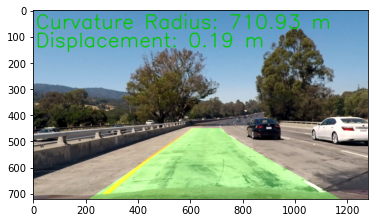

In [24]:
plt.imshow(pipeline(test_image_dist))

# Create Video

In [25]:
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip

RuntimeError: imageio.ffmpeg.download() has been deprecated. Use 'pip install imageio-ffmpeg' instead.'

In [ ]:
clip1 = VideoFileClip("project_video.mp4")
project_output = 'project_output.mp4'
clip = clip1.fl_image(pipeline)
%time clip.write_videofile(project_output, audio=False)